In [1]:
import numpy as np
from Bandits2 import Bandits
import matplotlib.pyplot as plt

In [ ]:
def linucb_fairness40(self, ind=[], max_T=500, steps=25, seed=0, la=0.16, delta=0.12, noisef=0.1, repeats=20, 
                    eps=[0.25], beta=[1], q_p=[0.2], q_w=[1], wid=[1], p=[0.25], p2=[0.25]):
    np.random.seed(seed)
    ret_ = [[], []]
    noise = np.mean(self.rewards) * noisef
    func = {0: self.LinUCB, 1: self.LinUCB_eps_greedy, 2: self.LinUCB_cost, 3: self.LinUCB_queue, -3: self.LinUCB_queue, 4: self.LinUCB_fairbounds,
            5: self.LinUCB_m, 6:self.LinUCB_m2}
    func_name = {0: "Linear UCB", 1: "ε-greedy", 2: "Diversity Cost", 3: "Queue", -3:"Queue", 4: "Fair Bounds", 5: "Fair Explore", 6: "Fair Explore2"}
    hp = {0: [""], 1: eps, 2: beta, 3: q_p, -3: q_w, 4: wid, 5:p, 6:p2}
    labe = {0: "", 1: ", ε=", 2: ", β=", 3: ", q_p=", -3: ", q_w=", 4: ", w=", 5:", p=", 6:", p2="}
    param = {0: [{"T": max_T, "steps":steps}],
             1: [{"T": max_T, "steps":steps, "eps":ep} for ep in eps],
             2: [{"T": max_T, "steps":steps, "beta":b} for b in beta],
             3: [{"T": max_T, "steps":steps, "q_p":qp, "q_w":q_w[0]} for qp in q_p],
             -3: [{"T": max_T, "steps":steps, "q_p":q_p[0], "q_w":qw} for qw in q_w],
             4: [{"T": max_T, "steps":steps, "wid":w} for w in wid],
             5: [{"T": max_T, "steps":steps, "p":p_} for p_ in p],
             6: [{"T": max_T, "steps":steps, "p":p2_} for p2_ in p2]}

    x = [int(np.floor(i * max_T / steps)) for i in range(1, steps+1)]
    y = {}
    con = {}
    freq = {}
    err = {}
    errcon = {}
    FSI = {}

    for i in ind:
        y[i] = [np.zeros((repeats, steps)) for l in range(len(param[i]))]
        con[i] = [np.zeros((repeats, steps)) for l in range(len(param[i]))]
        freq[i] = [np.zeros((self.C, self.K)) for l in range(len(param[i]))]
        err[i] = []
        errcon[i] = []
        FSI[i] = []
            
    assert len(np.unique(x)) == steps


    # Dependent variable
    # Run algorithms
    for i in ind:
        for l in range(len(param[i])):
            for r in range(repeats):
                y[i][l][r] += np.array(func[i](la, delta, noise, fixed=[True, r], **param[i][l])[4])
                con[i][l][r] += self.run_logs[self.run_count-1]["Consistency"]
                ca = self.chosen_arms()

                # Update chosen arms
                for c in range(self.C):
                    freq[i][l][c] += ca[0][c]
    
            err[i].append(np.std(y[i][l], axis=0, ddof=1) / np.sqrt(repeats))
            errcon[i].append(np.std(con[i][l], axis=0, ddof=1) / np.sqrt(repeats))
    
            self.df = freq[i][l]/repeats
            print(func_name[i], hp[i][l], self.df)
            G = self.Gini_fairness()
            E = self.mix() + G
            FSI[i].append(E[0])
        

    for i in ind:
        for l in range(len(param[i])):
            ret_[0].append(np.sum(y[i][l], axis=0)/repeats)

    for i in ind:
        for l in range(len(param[i])):
            ret_[1].append(np.sum(con[i][l], axis=0)/repeats)

    return ret_

In [ ]:
def lf_400(K, d, C, p, alg=[0, 1, 2, 3, 4, 5], repe=10):
    func_name = {0: "Linear UCB", 1: "ε-greedy", 2: "Diversity Cost", 3: "Queue", -3:"Queue", 4: "Fair Bounds", 5: "FDC", 6:"FDC"}
    alg_n = ['eps-greedy', 'cost', 'queue', 'bounds', 'm', 'm2']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#000000']
    plot1y = []
    plot2y = []
    plot3y = []

    for seed in range(repe):
        A = Bandits(K=K, d=d, C=C, p=p, seed=seed)
        A.generate_context(max_T=100 * K * d**2 //9, repeats=10)
        print(f"seed={seed}a")
        a = A.rf_curve(alg=[alg_n[i] for i in alg], max_T=100 * K * d**2 //9, la=0.16, delta=0.12, repeats=10, return_results=True)
        print(f"seed={seed}b")

        try:
            eps0 = [A.greedy_eps]
        except:
            eps0 = [0]
        try:
            beta0 = [A.cost_beta]
        except:
            beta0 = [0]
        try:
            q_p0 = [A.queue_q_p]
        except:
            q_p0 = [0]
        try:
            wid0 = [A.bounds_wid]
        except:
            wid0 = [0]
        try:
            p0 = [A.m_p]
        except:
            p0 = [0]
        try:
            p20 = [A.m_p2]
        except:
            p20 = [0]


        b = linucb_fairness40(A, ind=[i+1 for i in alg], max_T=100 * K * d**2 //9, steps=25, seed=0, la=0.16, delta=0.12, noisef=0.1, repeats=10, 
                    eps=eps0, beta=beta0, q_p=q_p0, q_w=[1], wid=wid0, p=p0, p2=p20)
        print(eps0, beta0, q_p0, wid0, p0, p20)
        plot1y.append(a)
        plot2y.append(b[0])
        plot3y.append(b[1])

    # Plot 1
    plt.figure()
    plot1y = np.array(plot1y)
    for i in range(len(alg)):
        x1 = np.mean(plot1y[:, i, 1, :], axis=0)
        xerr1 = np.std(plot1y[:, i, 1, :], axis=0, ddof=1) / np.sqrt(10)
        y1 = np.mean(plot1y[:, i, 0, :], axis=0)
        yerr1 = np.std(plot1y[:, i, 0, :], axis=0, ddof=1) / np.sqrt(10)
        plt.errorbar(x1, y1, xerr=xerr1, yerr=yerr1, label=func_name[alg[i]+1], linestyle='-', marker='o', markersize=2, color=colors[alg[i]])

    plt.grid()
    plt.legend()
    plt.ylabel("Fairness-Spread")
    plt.xlabel("Regret")
    plt.title("Relationship between fairness measure and regret")
    plt.show()


    # Plot 2
    plt.figure()
    plot2y = np.array(plot2y)
    x2 = [int(np.floor(i * 100 * K * d**2 //9 / 25)) for i in range(1, 25+1)]
    for i in range(len(alg)):
        y2 = np.mean(plot2y[:, i, :], axis=0)
        yerr2 = np.std(plot2y[:, i, :], axis=0, ddof=1) / np.sqrt(10)
        plt.errorbar(x2, y2, yerr=yerr2, label=f"{func_name[alg[i]+1]}", linestyle='-', marker='x', markersize=2, color=colors[alg[i]])
        
    plt.legend()
    plt.grid()
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cumulative Regret")
    plt.title("Relationship between # of iterations and cumulative regret")
    plt.show()

    # Plot 3
    plt.figure()
    plot3y = np.array(plot3y)
    x3 = [int(np.floor(i * 100 * K * d**2 //9 / 25)) for i in range(1, 25+1)]
    for i in range(len(alg)):
        y3 = np.mean(plot3y[:, i, :], axis=0)
        yerr3 = np.std(plot3y[:, i, :], axis=0, ddof=1) / np.sqrt(10)
        plt.errorbar(x3, y3, yerr=yerr3, label=f"{func_name[alg[i]+1]}", linestyle='-', marker='x', markersize=2, color=colors[alg[i]])
    plt.legend()
    plt.grid()
    plt.xlabel("Number of Iterations")
    plt.ylabel("Consistency")
    plt.title("Relationship between # of iterations and consistency")
    plt.show()

    return None

## $K=5$ 

seed=0a
0.14938015821857217
cost complete
0.14938015821857217
bounds complete
0.14938015821857217
m2 complete
seed=0b
Diversity Cost 47.05759666984172 [[0.2002 0.1872 0.2334 0.1866 0.1926]]
Fair Bounds 1.7721951312866517 [[0.143  0.1538 0.3966 0.156  0.1506]]
Fair Explore2 4.286733742926752 [[0.183  0.1506 0.3224 0.157  0.187 ]]
[0] [np.float64(47.05759666984172)] [0] [np.float64(1.7721951312866517)] [0] [np.float64(4.286733742926752)]
seed=1a
0.14938015821857217
cost complete
0.14938015821857217
bounds complete
0.14938015821857217
m2 complete
seed=1b
Diversity Cost 9.408101528224266 [[0.2324 0.0426 0.1554 0.337  0.2326]]
Fair Bounds 0.9641085118125011 [[0.1312 0.09   0.104  0.548  0.1268]]
Fair Explore2 3.1641456456646075 [[0.1918 0.048  0.1094 0.4254 0.2254]]
[0] [np.float64(9.408101528224266)] [0] [np.float64(0.9641085118125011)] [0] [np.float64(3.1641456456646075)]
seed=2a
0.14938015821857217
cost complete
0.14938015821857217
bounds complete
0.14938015821857217
m2 complete
seed=2b


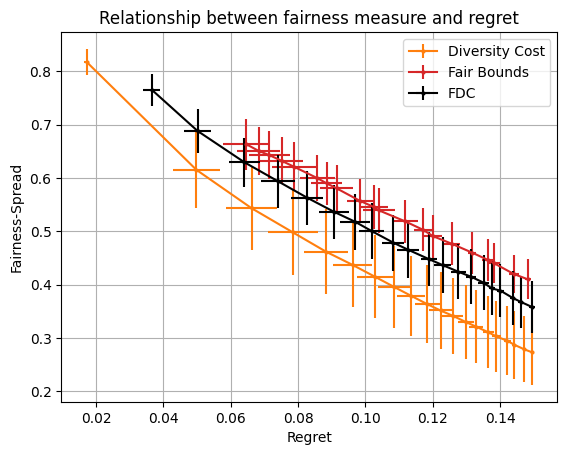

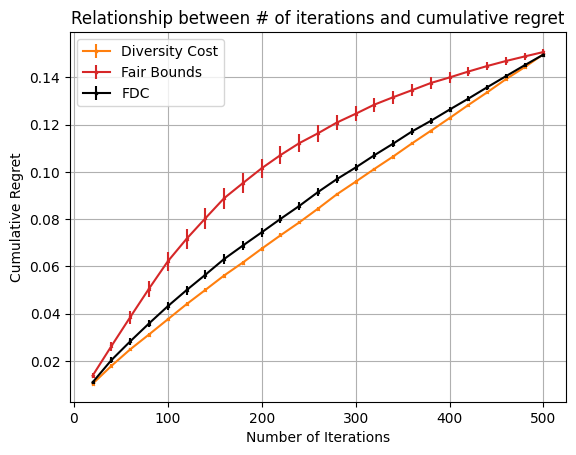

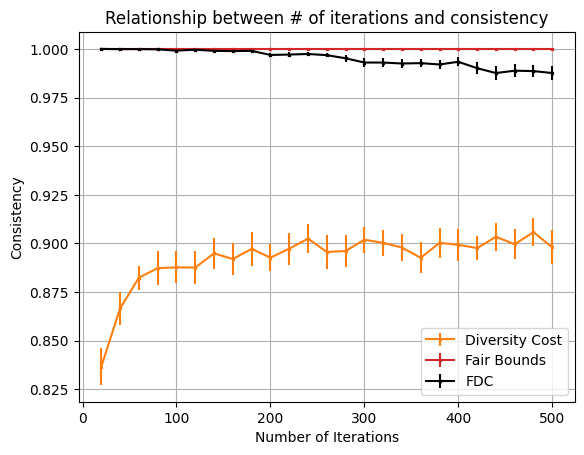

In [9]:
lf_400(5, 3, -1, 10, alg=[1, 3, 5], repe=10)

## $d=5$

seed=0a
0.12599210498948732
cost complete
0.12599210498948732
bounds complete
0.12599210498948732
m2 complete
seed=0b
Diversity Cost 1515.8673573804615 [[0.19733429 0.20662824 0.19769452 0.1945245  0.20381844]]
Fair Bounds 1.2831805838616646 [[0.19726225 0.21873199 0.20597983 0.17557637 0.20244957]]
Fair Explore2 117.03773234806746 [[0.19315562 0.2092219  0.18494236 0.20871758 0.20396254]]
[0] [np.float64(1515.8673573804615)] [0] [np.float64(1.2831805838616646)] [0] [np.float64(117.03773234806746)]
seed=1a
0.12599210498948732
cost complete
0.12599210498948732
bounds complete
0.12599210498948732
m2 complete
seed=1b
Diversity Cost 2.110784778228617 [[0.03544669 0.05122478 0.22730548 0.15907781 0.52694524]]
Fair Bounds 1.9066406183842302 [[0.07802594 0.07269452 0.07701729 0.07543228 0.69682997]]
Fair Explore2 1.2256132708711562 [[0.0537464  0.05252161 0.16887608 0.10172911 0.6231268 ]]
[0] [np.float64(2.110784778228617)] [0] [np.float64(1.9066406183842302)] [0] [np.float64(1.2256132708711

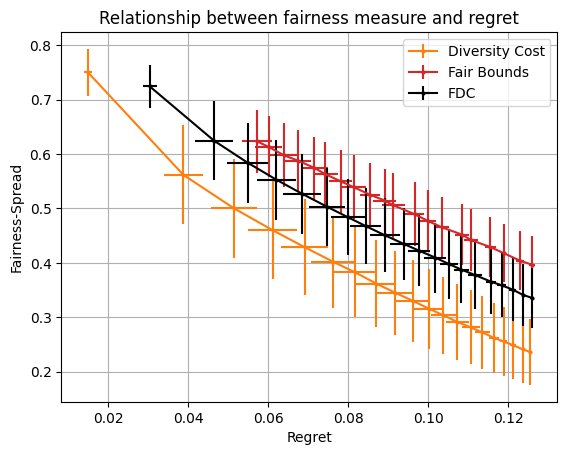

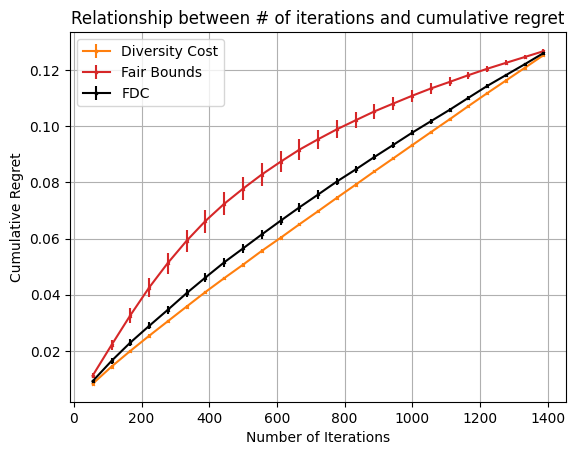

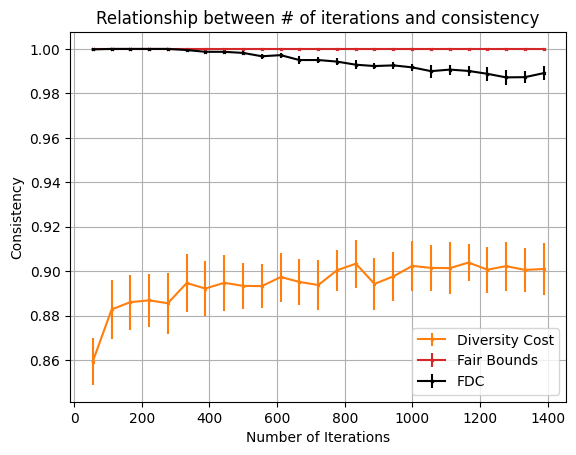

In [11]:
lf_400(5, 5, -1, 10, alg=[1, 3, 5], repe=10)

## $K=15$

seed=0a
0.14938015821857217
cost complete
0.14938015821857217
bounds complete
0.14938015821857217
m2 complete
seed=0b
Diversity Cost 21.094466258854048 [[0.07393333 0.02453333 0.13693333 0.05913333 0.08766667 0.01926667
  0.1582     0.10766667 0.00473333 0.1066     0.02946667 0.01086667
  0.11893333 0.01733333 0.04473333]]
Fair Bounds 0.13236079704698817 [[0.0334     0.03326667 0.07826667 0.0324     0.0328     0.0256
  0.50426667 0.0344     0.02606667 0.0316     0.03166667 0.0324
  0.04133333 0.0312     0.03133333]]
Fair Explore2 0.6505904344358673 [[0.034      0.03266667 0.14313333 0.03193333 0.03206667 0.02286667
  0.41593333 0.03913333 0.02186667 0.05133333 0.03146667 0.0322
  0.0546     0.0286     0.0282    ]]
[0] [np.float64(21.094466258854048)] [0] [np.float64(0.13236079704698817)] [0] [np.float64(0.6505904344358673)]
seed=1a
0.14938015821857217
cost complete
0.14938015821857217
bounds complete
0.14938015821857217
m2 complete
seed=1b
Diversity Cost 12.52670268997595 [[0.00853333 

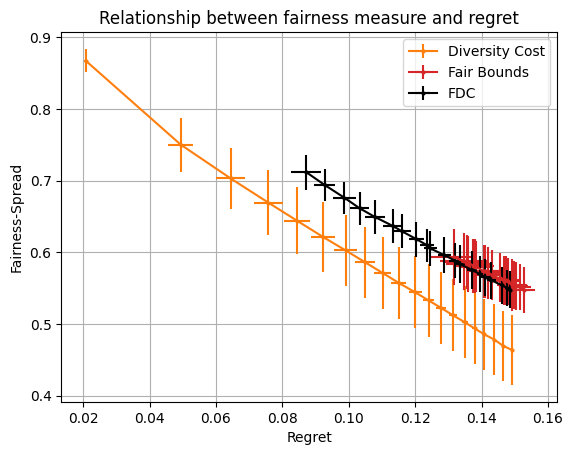

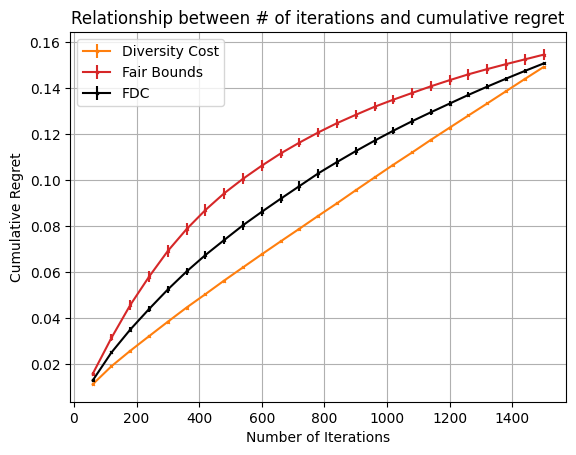

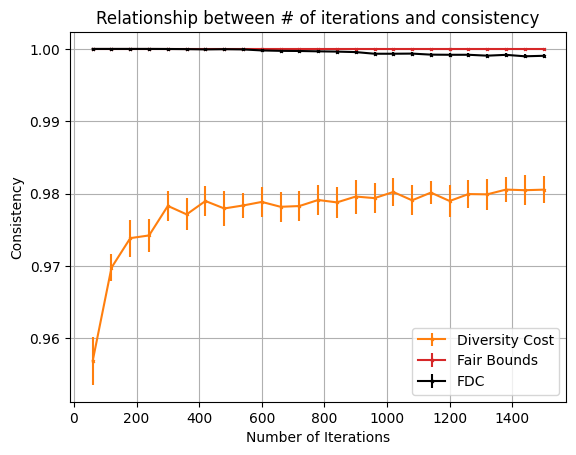

In [12]:
lf_400(15, 3, -1, 10, alg=[1, 3, 5], repe=10)